# Lab Deep Learning / Multi-Layer Perceptron for regression / in pytorch

**Author: geoffroy.peeters@telecom-paris.fr**

For any remark or suggestion, please feel free to contact me.

Last edits:
- 2020/03/24 peeters (change dimensions order)
- 2020/04/27 peeters (added comments on W1, W2 initialization, added comments on A and B)
- 2021/05/05 peeters (add some documentation related to ```W1 -= ...```)
- 2023/05/10 peeters (typos corrections)
- 2024/05/02 peeters (link to do nn.Linear)

Read the "introduction to pytorch"
- slides: https://perso.telecom-paristech.fr/gpeeters/doc/pytorch/
- video: https://perso.telecom-paristech.fr/gpeeters/video/pytorch.mp4


## Objective:

The objective of this lab is to demonstrate the use of Neural Networks to perform non-linear regression.
We will use a simple NN with 1 hidden layer. The hidden layer has $n_h$ (you will test various values of $n_h$) hidden units and either a ```sigmoid```, ```relu``` or ```tanh``` activation.
Since we perform a regression task the output $\hat{y} \in \mathbb{R}$ and  there is no output activation (linear).

You will perform 1000 iterations (epochs) of SGD to find the parameters.

You will then apply the network to the two datasets A and B.

Note: for this lab, we do not separate the dataset into a train, validation and test part. We simply check the ```capacity``` of the network to model the training data.

**Question**: according to the obtained loss, discuss the choice of ```sigmoid```, ```relu``` or ```tanh```.

<div class='alert alert-success'>
Answer:<br>
Since the resulting graph resembles a sine function (which is periodic and oscillates between -1 and 1) the most appropriate activation function to use in this case is the tanh function. Unlike ReLU or sigmoid, it is symmetric around zero and naturally outputs values within the range of -1 to 1.
</div>

### Data normalization

You should normalize the data to zero mean and unit standard deviation

### Model

There are various ways to write a NN model in pytorch.

In this lab, you will write three different implementations:
- **Model A**: manually defining the parameters (W1,b1,w2,b2), writting the forward equations, writting the loss equation, calling the .backward() and manually updating the weights using W1.grad. You will write the loop to perform 1000 epochs.
- **Model B**: using the Sequential class of pytorch
- **Model C**: a custom torch.nn.Module class for this.

For Model B and C, you will use the ready made loss and optimization from the nn and optim packages. You can use the same code to optimize the parameters of Model B and C.

### Loss

Since we are dealing with a regression problem, we will use a Mean Square Error loss: write it by-hand for Model A and use ```torch.nn.MSELoss``` for Model B and C.

### Parameters update/ Optimization

For updating the parameters, we will use as optimizer a simple SGD algorithm (use ```torch.optim.SGD``` for Model B and C) with a learning rate of 0.05.

Don't forget that an optimizer is applied to a set of parameters (```my_model.parameters()``` gives the parameters of the network for Model B and C).
Once the gradients have been computed (after the backpropagation has been performed), you can perform one step of optimization (using ```optimizer.step()``` for Model B and C).

### Backward propagation

Backpropagation is automatically performed in pytorch using the ```autograd``` package.
First, reset the gradients of all parameters (using ```optimizer.zero_grad()``` for Model B and C), then perform the backpropagation ```loss.backward()```.

### Regularization

- How can you add a Ridge (L2) regularization ? this can be done easely within the definition of the ```optimizer```.
- How can you add a Lasso (L1) regularization ? this has to be done manually at each iteration, by adding something to the loss before backpropagation.

**Question**: discuss the use of the Ridge and Lasso regularization for each dataset.

## Your task:

You need to add the missing parts in the code (parts between ```# --- START CODE HERE``` and ```# --- END CODE HERE```)

## Load the python packages

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

## Datasets

We will use two different datasets. For both $x$ has dimensions $(m,n_{in}=1)$ and $y$ has dimensions $(m,n_{out}=1)$ where $m$ is the number of examples.



In [49]:
def F_do_dataset_parab(m):
    x_data = torch.linspace(-1, 1, m)
    noise_data = 0.2*torch.rand(m)
    y_data = x_data.pow(2) + noise_data

    # --- change vectos to matrix
    x_data = torch.unsqueeze(x_data, dim=1)
    y_data = torch.unsqueeze(y_data, dim=1)
    return x_data, y_data

def F_do_dataset_sin(m):
    x_data = torch.arange(0, m, dtype=torch.float32)
    noise_data = 0.2*torch.rand(m)
    y_data = torch.sin(2*np.pi*x_data*0.001) + noise_data

    # --- change vectos to matrix
    x_data = torch.unsqueeze(x_data, dim=1)
    y_data = torch.unsqueeze(y_data, dim=1)
    return x_data, y_data

size of x_data: torch.Size([3000, 1])
size of y_data: torch.Size([3000, 1])


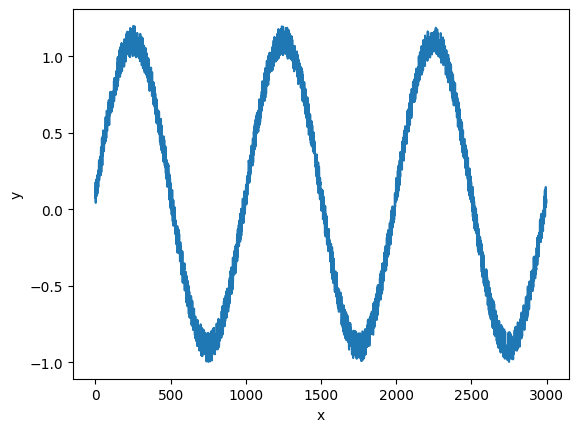

In [50]:
# --- Dataset 1
#x_data, y_data = F_do_dataset_parab(m=100)
# --- Dataset 2
x_data, y_data = F_do_dataset_sin(m=3000)

plt.plot(x_data.numpy(), y_data.numpy());
plt.xlabel('x'), plt.ylabel('y');

print('size of x_data:', x_data.size())
print('size of y_data:', y_data.size())

## Data standardization

We standardize the input data (substract mean and divide by standard-deviation)

In [51]:
# --- START CODE HERE (01)
x_data = (x_data - x_data.mean()) / x_data.std()
y_data = (y_data - y_data.mean()) / y_data.std()
# --- END CODE HERE

## Hyper-parameters definition

In [52]:
n_in = 1
n_h = 10
n_out = 1

nb_epoch = 20000
learning_rate_alpha = 0.05
param_momentum = 0.01
param_L1_weight = 0.001
param_L2_weight = 0.01

## Model A (writting the network equations)

For model A, you will define the variables and write the equations of the network yourself (as you would do in numpy).
However you will use ```torch tensors``` instead of ```numpy array```.

***Why ?*** because torch tensors will allows you to automatically get the gradient. You will use ```loss.backward()``` to launch the backpropagation from the ```loss``` variable.
Then, for all torch tensors you have created and for which you have declared ```requires_grad=True```, you will get the gradient of ```loss```with respect to this variable in the field ```.grad```.

***Example*** ```W1 = torch.tensors(..., requires_grad=True)``` ... ```loss.backward()``` will have the gradient $\frac{d Loss}{d W1}$ in ```W1.grad```.

### Initialize the variables

**Note**: In order to avoid neuron saturation and that all the neurons learn the same thing, the matrix should be initialized to a small random value (see https://pytorch.org/docs/stable/generated/torch.nn.Linear.html for details). Because of this, W1 and W2 should be first define as small random; **then** set to ```requires_grad=True```.

In [53]:
# --- START CODE HERE (02)
W1 = torch.randn((n_in, n_h), requires_grad=True)
b1 = torch.randn((1, n_h), requires_grad=True)
W2 = torch.randn((n_h, n_out), requires_grad=True)
b2 = torch.randn((1, n_out), requires_grad=True)
# --- END CODE HERE

### Define the model

We will denote by ```H``` the pre-activation (value before the non-linearity) and by ```A``` the activation (value after the non-linearity).

In [54]:
def modelA(X, activation_function='relu'):

    # --- H is the results of the first projection
    # --- H is then transformed by a non-linearity to A

    # --- START CODE HERE (03)
    H = torch.mm(X, W1) + b1 # pre-activation

    match activation_function:
        case 'tanh':
            A = torch.tanh(H) # tanh activation function
        case 'relu':
            A = F.relu(H) # relu activation function
        case 'sigmoid':
            A = torch.sigmoid(H) # sigmoid activation function
    
    y_pred = torch.mm(A, W2) + b2
    # --- END CODE HERE
    return y_pred

### Train the model

**Note**: when updating the parameters (W1,b1,W2,b2) you should use an "in-place" update: ```W1 -= ...``` instead of ```W1 = W1 - ...```; otherwise ```W1``` will be replaced by its value and its gradient field will not exist anymore.

In [55]:
learning_rate_alpha=0.05

In [56]:
for epoch in range(0, nb_epoch):
    # --- X (m, n_in)
    # --- Y (m, n_out)
    # --- START CODE HERE (04)
    y_pred = modelA(x_data, activation_function='tanh')
    # define MSE loss
    loss = torch.mean((y_pred - y_data) ** 2)
    # --- END CODE HERE

    if epoch % 1000 == 0:
        print('epoch {}, loss {}'.format(epoch, loss))

    loss.backward()

    with torch.no_grad():
        # --- START CODE HERE (05)
        W1 -= learning_rate_alpha * W1.grad
        b1 -= learning_rate_alpha * b1.grad
        W2 -= learning_rate_alpha * W2.grad
        b2 -= learning_rate_alpha * b2.grad
        # --- END CODE HERE
        W1.grad.zero_()
        b1.grad.zero_()
        W2.grad.zero_()
        b2.grad.zero_()


epoch 0, loss 2.2802700996398926
epoch 1000, loss 0.19850420951843262
epoch 2000, loss 0.0898817926645279
epoch 3000, loss 0.07150484621524811
epoch 4000, loss 0.06002115458250046
epoch 5000, loss 0.05192354694008827
epoch 6000, loss 0.04565585404634476
epoch 7000, loss 0.04003322497010231
epoch 8000, loss 0.03473397344350815
epoch 9000, loss 0.029749872162938118
epoch 10000, loss 0.025182731449604034
epoch 11000, loss 0.02116435579955578
epoch 12000, loss 0.017824389040470123
epoch 13000, loss 0.015226548537611961
epoch 14000, loss 0.013312768191099167
epoch 15000, loss 0.011941693723201752
epoch 16000, loss 0.010962534695863724
epoch 17000, loss 0.010252502746880054
epoch 18000, loss 0.009723592549562454
epoch 19000, loss 0.009316939860582352


### Plotting the results

We will super-impose the biases of the first layer to better understand how the model has fit the sinusoidal curve. Please explain what it does.

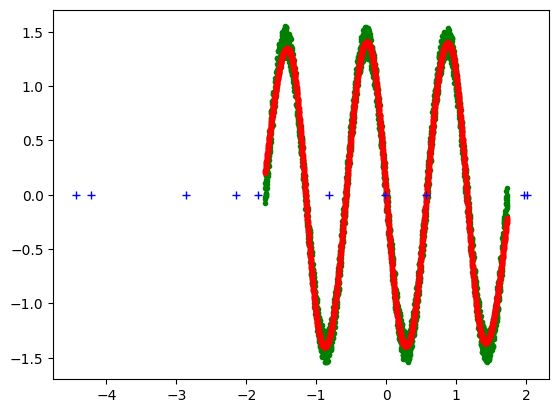

In [57]:
# ----------------
plt.plot(x_data.numpy(), y_data.numpy(), 'g.');
plt.plot(x_data.numpy(), y_pred.detach().numpy(), 'r.');
# super-impose the biases of the first layer
plt.plot(b1.detach().numpy(), np.zeros((1,10)), 'b+');

## Model B (using Sequential class)

Here, you will write the network using the nn.Sequential class.
With this you can use the ready-made layers ``torch.nn.Linear``,``torch.nn.Tanh``, ...

In [58]:
# --- START CODE HERE (06)
modelB = torch.nn.Sequential(
    torch.nn.Linear(n_in, n_h),
    torch.nn.Tanh(),
    torch.nn.Linear(n_h, n_out)
)

MSEloss = torch.nn.MSELoss()
optimizer = torch.optim.SGD(modelB.parameters(), lr=learning_rate_alpha, momentum=param_momentum)

for epoch in range(0, nb_epoch):
    # --- X (m, n_in)
    # --- Y (m, n_out)

    y_pred = modelB(x_data)
    loss = MSEloss(y_pred, y_data)

    loss.backward()
    optimizer.step()


    if epoch % 1000 == 0:
        print('epoch {}, loss {}'.format(epoch, loss))

    with torch.no_grad():
        modelB.zero_grad()
        optimizer.zero_grad()
        
# --- END CODE HERE

epoch 0, loss 1.092717170715332
epoch 1000, loss 0.87923264503479
epoch 2000, loss 0.8428316116333008
epoch 3000, loss 0.7821463346481323
epoch 4000, loss 0.6268718242645264
epoch 5000, loss 0.4440929889678955
epoch 6000, loss 0.09319115430116653
epoch 7000, loss 0.06739705801010132
epoch 8000, loss 0.057631317526102066
epoch 9000, loss 0.049902044236660004
epoch 10000, loss 0.04287354648113251
epoch 11000, loss 0.03626611828804016
epoch 12000, loss 0.030296824872493744
epoch 13000, loss 0.025143349543213844
epoch 14000, loss 0.020969020202755928
epoch 15000, loss 0.017803547903895378
epoch 16000, loss 0.015465879812836647
epoch 17000, loss 0.013744862750172615
epoch 18000, loss 0.01248249039053917
epoch 19000, loss 0.011557669378817081


## Model C (using a class definition)

Here, you will write the network using the recommended pytorch way; i.e. by defining a class.
This class inherit from the main class ```torch.nn.Module```.
You only need to write the ```__init__``` method and the ```forward``` method.

In object programming, the ```__init__``` method defines the attributes of your class. Since the attributes of your  network are the parameters to be trained (weights and biases), you should declare in the ```__init``` all the layers that involve parameters to be trained (mostly the ```Linear```layers which perform the matrix multiplication).

The ```forward``` method contains the code of the forward pass itself. It can of course call attributes defined in the ```__init___``` method. It is the method used when calling ```model(x)```.

As before, the model created will have all its parameters accessible as a dictionary and can be accessed using ```model.parameters()```.

Classes are convenient way to write more complex network than what you can do with ```nn.sequential```. Note that you can actually include a ```nn.sequential``` in your class.

In [59]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # --- START CODE HERE (07)
        self.W1 = torch.nn.Linear(n_in, n_h)
        self.W2 = torch.nn.Linear(n_h, n_out)
        self.activation = F.tanh
        # --- END CODE HERE

    def forward(self, x):

        # --- START CODE HERE (08)
        H = self.W1(x)
        A = self.activation(H)
        y_pred = self.W2(A)
        # --- END CODE HERE

        return y_pred

# --- START CODE HERE (08)
modelC = Net()
# --- END CODE HERE

## Model B+C

### Criterion and Optimization

The code of Model A is self-contained, i.e. it already contains all necessary instruction to perform forward, loss, backward and parameter updates.

When using ```nn.sequential``` (model B) or a class definition of the network (model C), we still need to define
- what we will minimize (the loss to be minimized, i.e. Mean-Square-Error or Binary-Cross-Entropy). We can of course write the equation of it by hand but pytorch comes with a very large number of pre-build loss functions (within ```torch.nn```)
- how we will minimize the loss, i.e. what parameter update alogirhtms we will use (SGD, momentum). We can of course write the equation of it by hand but pytorch comes with a very large number of pre-build loss functions (within ```torch.nn```)

L2 regularization can be done directly in the optimizer under the name ```weight_decay```.

In [60]:
# --- START CODE HERE (09)
optimizer = torch.optim.SGD(
    modelC.parameters(), 
    lr=learning_rate_alpha, 
    # momentum=param_momentum,
    # weight_decay=param_L2_weight
    )

loss_function = torch.nn.MSELoss()
# --- END CODE HERE

### Training

Having defined the network, the citerion to be minimized and the optimizer, we then perform a loop over epochs (iterations); at each step we
- compute the forward pass by passing the data to the model: ```haty = model(x)```
- compute the the loss (the criterion)
- putting at zero the gradients of all the parameters of the network (this is important since, by default, pytorch accumulate the gradients over time)
- computing the backpropagation (using as before ```.backward()```)
- performing one step of optimization (using ```.step()```)

In [61]:
loss_l = []
for epoch in range(nb_epoch):

    # --- START CODE HERE (10)
    y_pred = modelC(x_data)
    loss = loss_function(y_pred, y_data)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # --- END CODE HERE

    loss_l.append(loss)
    if epoch % 1000 == 0:
        print('epoch {}, loss {}'.format(epoch, loss.data))

epoch 0, loss 0.995078444480896
epoch 1000, loss 0.8780840039253235
epoch 2000, loss 0.8387576341629028
epoch 3000, loss 0.8072550296783447
epoch 4000, loss 0.7716149687767029
epoch 5000, loss 0.7320770621299744
epoch 6000, loss 0.6993494629859924
epoch 7000, loss 0.6758449077606201
epoch 8000, loss 0.6571770906448364
epoch 9000, loss 0.6282021999359131
epoch 10000, loss 0.5632336139678955
epoch 11000, loss 0.05189201235771179
epoch 12000, loss 0.0434638075530529
epoch 13000, loss 0.03922340273857117
epoch 14000, loss 0.035479284822940826
epoch 15000, loss 0.0322464220225811
epoch 16000, loss 0.02937167137861252
epoch 17000, loss 0.026807714253664017
epoch 18000, loss 0.024580711498856544
epoch 19000, loss 0.02269366942346096


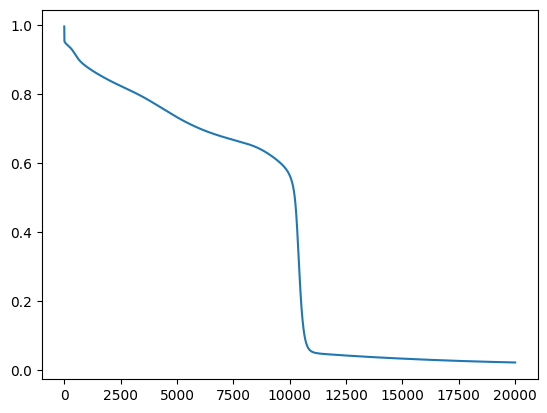

In [62]:
# ----------------
plt.plot([loss.detach().numpy() for loss in loss_l]);

### Plotting results

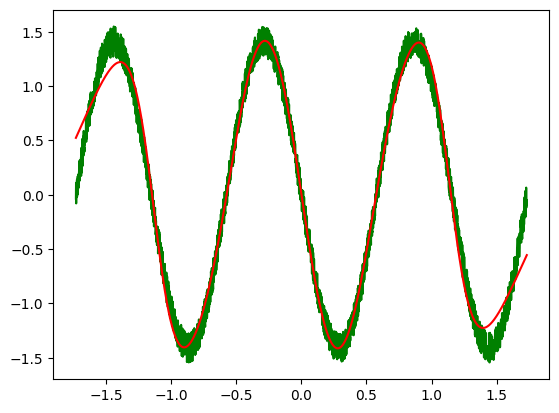

In [63]:
# ----------------
plt.plot(x_data.numpy(), y_data.numpy(), 'g')
plt.plot(x_data.numpy(), y_pred.detach().numpy(), 'r')

### Display the weights and the biases

Now, we want to check the effect of L1 regularization. For this you will plot the values of the weights of each layers.

[[-0.4802458 ]
 [ 3.0215085 ]
 [-0.3905359 ]
 [ 5.2733493 ]
 [ 0.93070847]
 [ 5.2542715 ]
 [ 0.7737521 ]
 [ 1.0512762 ]
 [-3.3561344 ]
 [ 3.6631496 ]]
[-0.4861658  -0.02937957 -0.03748633  5.9762783   1.4152064  -5.9655285
  1.1168084  -1.631482    1.6504029   1.83682   ]
[[-0.85004246 -3.7728753  -1.1450994  -2.4161625   1.4406894  -2.394429
   1.1040876   2.2581103  -2.1418567   1.8523558 ]]
[-0.35434738]


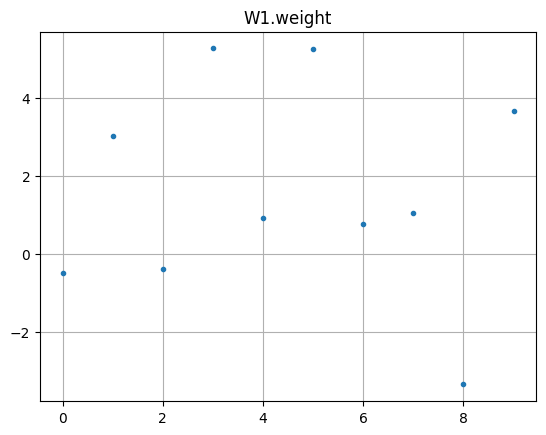

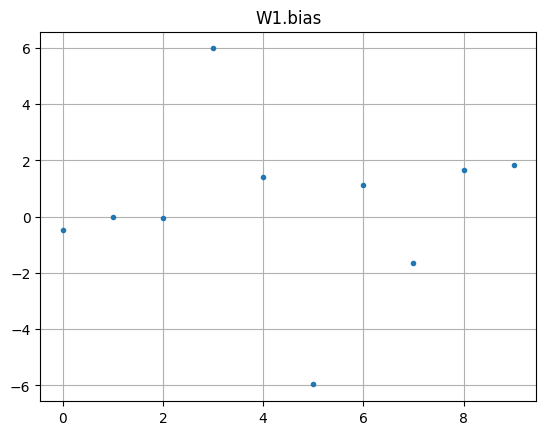

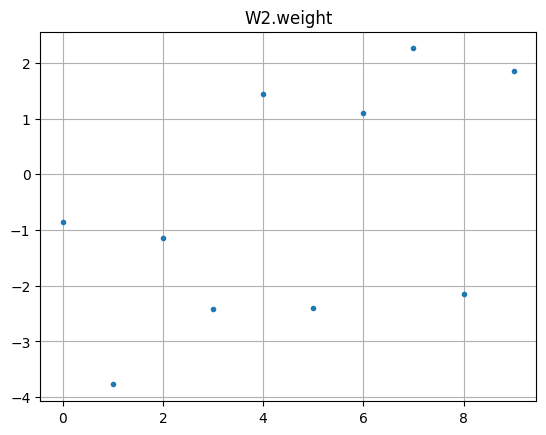

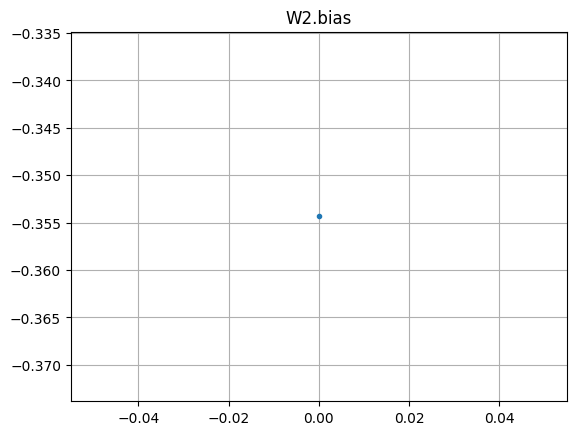

In [64]:
list_l = [{'name':name, 'data':layer.data} for name, layer in modelC.named_parameters()]
for tmp in list_l:
    plt.figure()
    plt.plot(tmp['data'].flatten().numpy(), '.')
    plt.title(tmp['name'])
    plt.grid(True)
    print(tmp['data'].numpy())

# Peer-grading

To great the Lab, you will apply the following:
- When the code of a part (each part is numbered as "START CODE (01)" ... "START CODE (10)") is correct you get 1 point.
- So the total for Lab is 10 points.